###### Additional Functions

In [58]:
import numpy as np
import math

# Input 3 numpy arrays (a, b, f) size of N:
# y[i-1] + a[i] * y[i] + b[i] * y[i+1] = f[i], where i = [1, N]
#
# Note: a[0], b[0] - unusable
def SolveSweepMethod (a, b, f, y_0, y_N):
    N = a.size

    # First sweep
    a_, f_ = np.zeros (N), np.zeros (N)
    f_[0] = y_0
    for i in range (1, N):
        z = a[i] + a_[i - 1]
        a_[i] = -b[i] / z
        f_[i] = (f[i] - f_[i - 1]) / z
    
    # Second sweep
    y = np.zeros (N + 1)
    y[0], y[N] = y_0, y_N
    for i in range (N - 1, 0, -1):
        y[i] = a_[i] * y[i+1] + f_[i]

    return y

def linearize (X, Y):
  A = np.vstack ([X, np.ones (X.size)]).T
  k, b = np.linalg.lstsq (A, Y, rcond=None)[0]

  return k, b

def printErrorPower (h_arr, err_arr):
    k, b = linearize (np.log (h_arr), np.log (err_arr))
    print (f"Error O(h^{k:0.2})")

def plotSolveAndAnswer (solve_x, solve_y, answer_x, answer_y, dpi=100):
    plt.figure (dpi=dpi)
    plt.xlabel ('y(x)')
    plt.ylabel ('x')
    plt.plot (solve_x, solve_y, label='solve', linewidth=3)
    plt.legend ()
    plt.plot (answer_x, answer_y, label='answer', linestyle='-.', linewidth=1)
    plt.legend ()

def plotError (h_arr, err_arr, dpi=100):
    plt.figure (dpi=dpi)
    plt.title ('lg(err (lg (h)))')
    plt.xlabel ('lg (h)')
    plt.ylabel ('lg (err)')
    plt.plot (np.log10 (h_arr), np.log10 (err_arr))

# Cтационарное одномерное уравнение диффузии


In [59]:
import numpy as np
import matplotlib.pyplot as plt

def func_solve (x):
    # t2 = (x - 0.5) * (x - 0.5)
    # return np.exp (-t2) - np.exp (-1/4)
    # return x * (1 - x)
    # return x * (1 - x) * np.exp (x)
    return x * (1 - x) * np.exp (x)

def f (x, k, v):
    # t = x - 0.5
    # t2 = t*t
    # return np.exp (-t2) * (k * (2 - 4 * t2) - 2 * v * t)
    # return 2 * k + v * (1 - 2 * v)
    return np.exp (x) * (k * (x*x + 3*x) + v * (1 - x - x*x))

In [60]:
def calc_err (y_ref, y):
    return np.max (np.abs (y - y_ref))

# f > 0 on [a, b], because check:
def check_f (x, f, k, V):
    if np.any (f (x, k, V) < 0):
        raise Exception ("exist x : f(x) < 0")

## Метод конечных объёмов со 2-ым порядком

Pe = 13.443661032028775
Pe = 7.037783623451869
Pe = 3.6044551695329736
Pe = 1.8244606718532927
Pe = 0.9178953169695384
Error O(h^2.2)


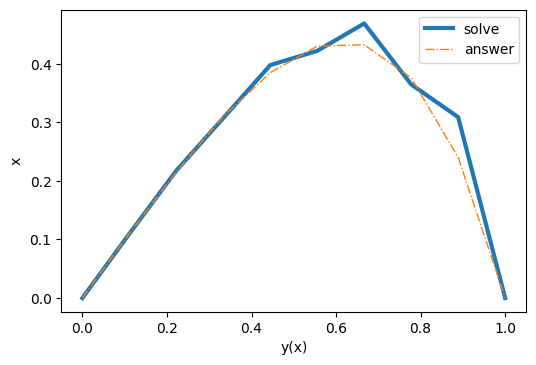

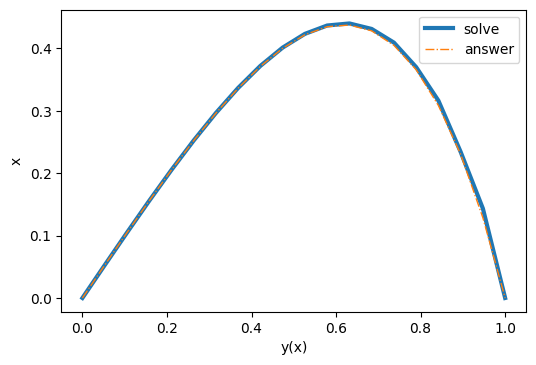

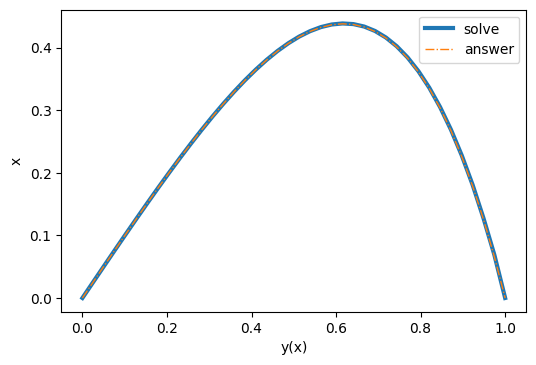

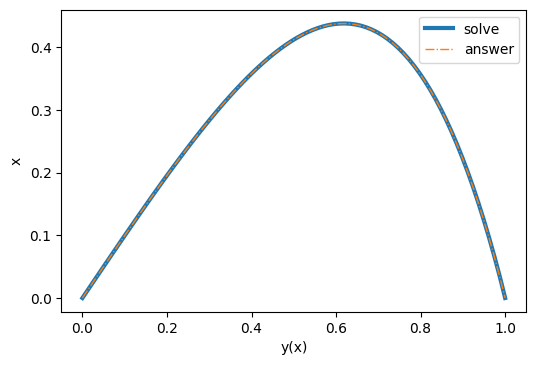

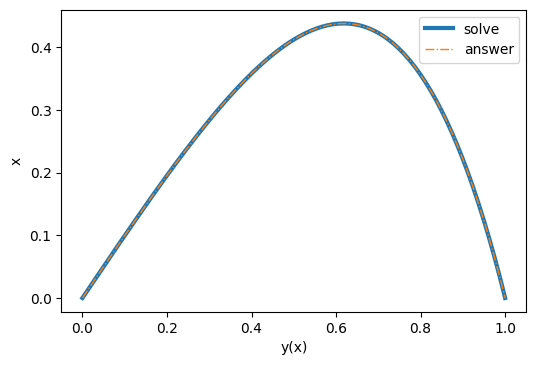

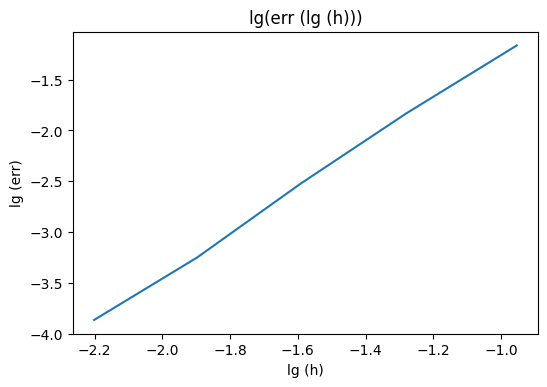

In [61]:
# x - array with size N + 1 => x[0], ..., x[N]
# k - number
# V - array with size N + 1
# f - array with size N + 1
def solve_finite_volumes_v2 (x, k, V, f):
    N = x.size - 1
    a, b, phi = np.zeros (N), np.zeros (N), np.zeros (N)

    # Calc a, b, phi
    for i in range (1, N):
        d_l = x[i] - x[i-1]
        d_r = x[i+1] - x[i]
        h_i = (d_l + d_r) / 2

        v_l = (V[i-1] + V[i]) / 2
        v_r = (V[i] + V[i+1]) / 2

        g = -k / d_l - v_l / 2
        a[i] = (k / d_l + k / d_r + (v_r - v_l) / 2 - (v_r - v_l)) / g
        b[i] = (v_r / 2 - k / d_r) / g
        phi[i] = (f[i] * h_i) / g

    # Solve sweep method
    return SolveSweepMethod (a, b, phi, 0, 0)

def calc_Pe_max (x, k, V):
    return np.max ([(x[i] - x[i-1]) * np.abs (V[i]) / k for i in range (1, x.size)])

def main_finite_volumes ():
    N_begin = 10
    num_N = 5
    a, b = 0, 1

    k = 1e0

    N = N_begin
    h_arr, err_arr = np.zeros (num_N), np.zeros (num_N)
    for i in range (num_N):
        x = np.linspace (a, b, N)

        V0 = 20
        V_arr = np.array ([V0 * np.exp (2*i / N) for i in range (N)])
        f_arr = np.array ([f (x[i], k, V_arr[i]) for i in range (N)])
        # plt.plot (x, f_arr)
        # check_f (x, f, k, V_arr) # f > 0
        y = solve_finite_volumes_v2 (x, k, V_arr, f_arr)
        
        # if i == 0:
        plotSolveAndAnswer (x, y, x, func_solve (x))

        Pe_max = calc_Pe_max (x, k, V_arr)
        print (f'Pe = {Pe_max}')

        # Save error
        h_arr[i] = x[1] - x[0]
        err_arr[i] = calc_err (y, func_solve (x))
        N = N * 2
    
    plotError (h_arr, err_arr)
    printErrorPower (h_arr, err_arr)

main_finite_volumes ()

## Монотонизирующая схема

Pe = 1.1700423432400904
Pe = 1.7578294397584098
Pe = 1.9836896484305127
Pe = 1.8022275847664866
Pe = 0.9122303359266463
Pe = 0.45894765848476915
Pe = 0.2301886682013178
Error O(h^1.8)


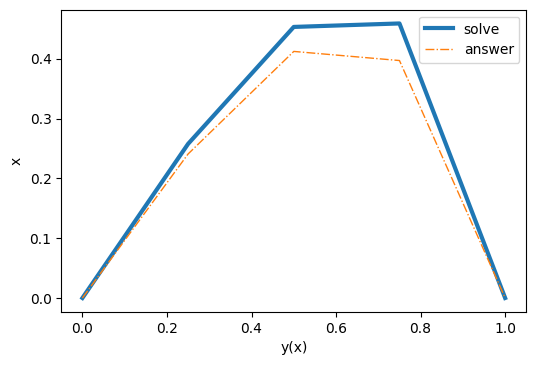

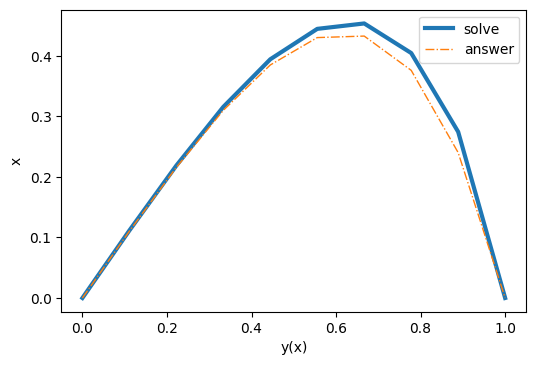

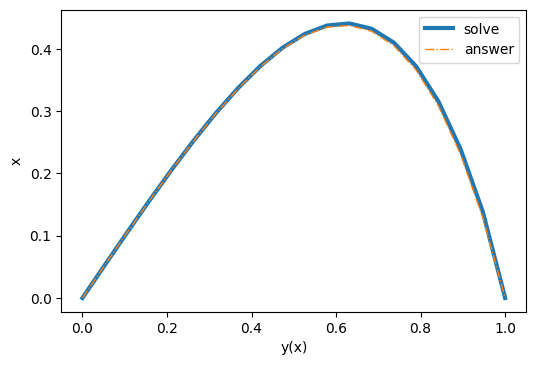

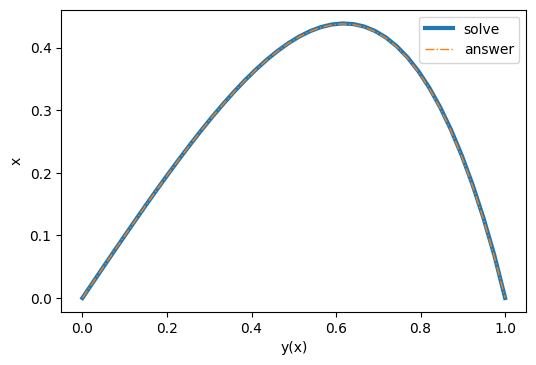

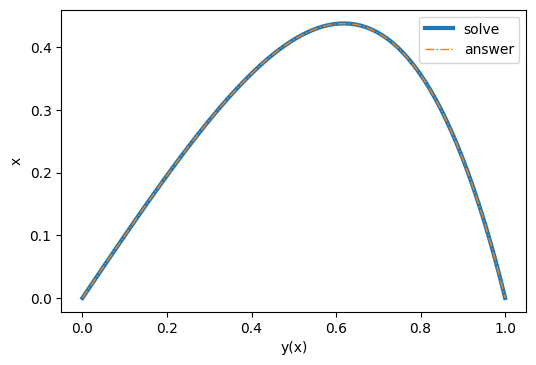

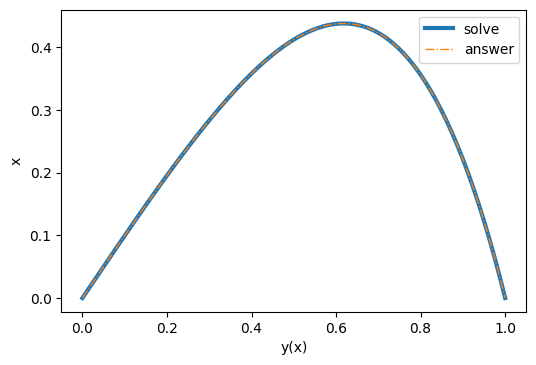

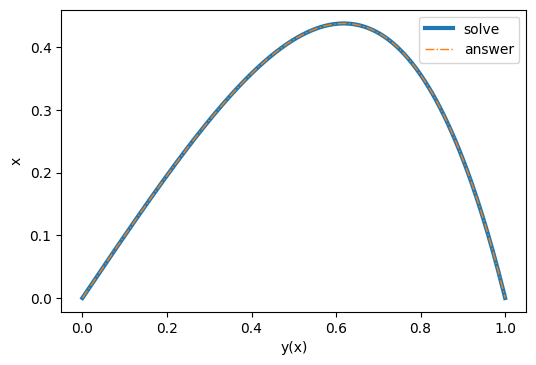

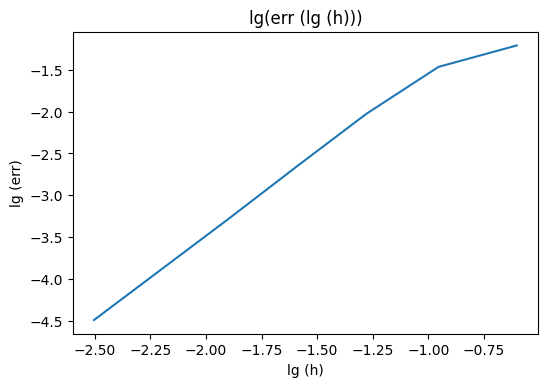

In [15]:
def main_finite_volumes_with_monotonizator ():
    N_begin = 5
    num_N = 7
    a, b = 0, 1

    alpha = 1 / 16

    k = 1e-1

    N = N_begin
    h_arr, err_arr = np.zeros (num_N), np.zeros (num_N)
    for i in range (num_N):
        x = np.linspace (a, b, N)

        V0 = 1
        V_arr = np.array ([V0 * np.exp (2*i / N) for i in range (N)])
        
        Pe_max = calc_Pe_max (x, k, V_arr)
        k_cur = k * (1 if Pe_max < 2 else 1 + alpha * Pe_max * Pe_max)

        f_arr = np.array ([f (x[i], k_cur, V_arr[i]) for i in range (N)])
        # plt.plot (x, f_arr)
        # check_f (x, f, k_cur, V_arr) # f > 0
        y = solve_finite_volumes_v2 (x, k_cur, V_arr, f_arr)
        
        # if i == 0:
        plotSolveAndAnswer (x, y, x, func_solve (x))

        Pe_max = calc_Pe_max (x, k_cur, V_arr)
        print (f'Pe = {Pe_max}')

        # Save error
        h_arr[i] = x[1] - x[0]
        err_arr[i] = calc_err (y, func_solve (x))
        N = N * 2
    
    plotError (h_arr, err_arr)
    printErrorPower (h_arr, err_arr)

main_finite_volumes_with_monotonizator ()

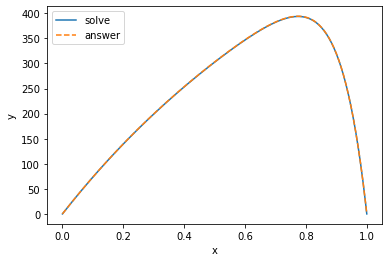

Error O(h^0.87)


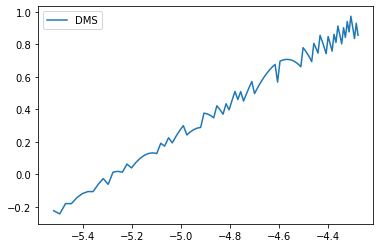

In [68]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as patches
import numpy as np
import math
import random
import scipy.optimize
from scipy.optimize import least_squares

def sweep(A, b):
    n = len(b)
    y = [0 for row in range(n)]
    alpha = [0 for row in range(n)]
    beta = [0 for row in range(n)]
    
    if A[0][0] == 0:
        return 0
    
    y[0] = A[0][0]
    alpha[0] = -A[0][1] / y[0]
    beta[0] = b[0] / y[0]
    
    # forward
    for i in range(1, n):
        y[i] = A[i][i] + alpha[i-1] * A[i][i-1]
        
        if y[i] == 0:
            return 0
        
        if i < n - 1:
            alpha[i] = -A[i][i+1] / y[i]
        beta[i] = (b[i] - A[i][i-1]*beta[i-1])/y[i]
        
    # backward and result
    b[n-1] = beta[n-1]
    
    for i in range(n-2, -1, -1):
        b[i] = alpha[i] * b[i+1] + beta[i]
    return 1

def gridMethodLinear(a, b, YaTrue, YbTrue, h, p, q, f):
    N = int((b - a) / h)
    
    xs = np.arange(a, b, h)
    xs = np.append(xs, 1)
    
    A = [1/h**2 + p(xs[i]) / (2*h)  for i in range(N)]
    B = [-2/h**2 + q(xs[i]) for i in range(N)]
    C = [1/h**2 - p(xs[i]) / (2*h) for i in range(N)]
    D = [f(xs[i]) for i in range(N)]
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+1)])
    MAT[0][0] = 1
    VEC.append(YaTrue)
    
    for i in range(1, N):
        ADD = [0 for i in range(N+1)]
        ADD[i - 1] = C[i]
        ADD[i] = B[i]
        ADD[i + 1] = A[i]
        MAT.append(ADD)
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+1)])
    MAT[-1][-1] = 1
    VEC.append(YbTrue)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)
    
    return xs, ys



def DMS(k, V, f, h):
    N = int(1 / h)
    
    xs = np.arange(0, 1, h)
    xs = np.append(xs, 1)
        
    def V_(i, half):
        if half == 0.5:
            return V((xs[i + 1] + xs[i])/2) 
        if half == 0:
            return V(xs[i])
        if half == -0.5:
            return V((xs[i-1] + xs[i])/2)
    
    def VP(i, half):
        return 0.5 * (V_(i, half) + math.fabs(V_(i, half)))
    
    def VM(i, half):
        return 0.5 * (V_(i, half) - math.fabs(V_(i, half)))
    
    C = [-(-k/h**2 + VM(i, 0.5)/h) for i in range(N)]
    B = [-(2*k/h**2 + VP(i, 0.5)/h - VM(i, -0.5)/h) for i in range(N)]
    A = [-(-VP(i, -0.5) / h - k/h**2)  for i in range(N)]
    D = [f(xs[i]) for i in range(N)]
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+1)])
    MAT[0][0] = 1
    VEC.append(0)
    
    for i in range(1, N):
        ADD = [0 for i in range(N+1)]
        ADD[i - 1] = C[i]
        ADD[i] = B[i]
        ADD[i + 1] = A[i]
        MAT.append(ADD)
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+1)])
    MAT[-1][-1] = 1
    VEC.append(0)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)

    return xs, ys, [V_(i, 0) * h / k for i in range(0, N+1)]


def V1(x):
    return 1

def f1(x):
    return -math.pi**2 * math.sin(math.pi * x) + math.pi * V(x) * math.cos(math.pi * x)

def V(x):
    return math.exp(10*x)-10

def f(x):
    return (-12*x**2 + 0.6*x + 6.2) + V(x) * (-4*x**3 + 0.3*x**2 + 6.2*x - 2.2)



    
def makeGraph(func, h):
    xs, ys, Pe = func(1, V1, f1, h)


    fig, ax = plt.subplots(1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.plot(xs, ys, label = "solve")

    xs, ys = gridMethodLinear(0, 1, 0, 0, h, V1, lambda x: 0, f1)

    ax.plot(xs, ys, '--', label = "answer")

    ax.legend()

    plt.show()
    
def calcInfl(h, func, VV, ff, met):
    err = 0
    xs, ys, Pe = met(1, VV, ff, h)
    for i in range(0, min(len(xs), len(ys))):
        err = max(err, math.fabs(func(xs[i]) - ys[i]))
    return err

def calcInfl_(h):
    err = 0
    xs, ys, Pe = DMS(1, V1, f1, h)
    xs1, ys1 = gridMethodLinear(0, 1, 0, 0, h, V1, lambda x: 0, f1)
    for i in range(0, min(len(ys1), len(ys))):
        err = max(err, math.fabs(ys1[i] - ys[i]))
    return err

def trueF(x):
    return math.sin(math.pi * x)

def check(xs, arr):
    res = []
    xs_res = []
    for i in range(1, len(arr) - 1):
        if (arr[i-1] > arr[i] and arr[i+1] > arr[i]):
            res.append(2*xs[i])
            xs_res.append(xs[i])
    return np.array(xs_res), np.array(res)

def drawInfl():
    hs = np.arange(0.004, 0.014, 0.0001)
    
   
    infls = []
    
    for h in hs:
        
        infl = calcInfl_(h)
        
       
        infls.append(infl)
        
    fig, ax = plt.subplots()
    
    
    infls = np.array(infls)
    
    hs = np.array([math.log(h) for h in hs])
   
    infls = np.array([math.log(infl) for infl in infls])
    

    
    
    k = (infls[-1] - infls[0]) / (hs[-1] - hs[0])
    
    
    print(f"Error O(h^{k:0.2})")
    
    
    ax.plot(hs, infls, label = "DMS")

    ax.legend()

    plt.show()


makeGraph(DMS, 0.002)
drawInfl()